# SSAC - Exploration 17 - Session Based Recommendation
---
Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작.

## 데이터 셋 불러오기

In [4]:
import datetime as dt
from pathlib import Path
import os
from datetime import datetime

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.    
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [6]:
# 전체 데이터 길이
len(data)

1000209

In [73]:
# 중복데이터 검사
data.duplicated().sum()

0

In [7]:
#추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [8]:
# 각 아이디 별 평점 데이터 몇개정도를 갖는지도 살펴보겠습니다.
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [9]:
user_length.median(), user_length.mean(), user_length.std()

(96.0, 165.5975165562914, 192.74702906977777)

In [10]:
user_length.min(), user_length.max()

(20, 2314)

+ 아이디별 평점을 준 기록의 표준편차가 192로 평균이 165으로 데이터가 상당히 넓게 분포되어 있는 것으로 보인다.
  + 익명의 사용자의 접속데이터인 session이 대부분 하루 특정 시간대에 접속 후 짧은 시간 내에 sequence가 끝나는 짧은 기간의 데이터 였던 반면 영화 평점 데이터는 아이디 별로 장기간에 걸쳐 축적될 수 있는 형태의 데이터이기 때문에 세션 기반 추천 시스템을 학습시키기 위해서 세션과 유사한 형태로 구성하기 위한 고민이 필요해 보인다. 
+ 상품 구매 행태는 한달을 주기로 변화하는 특성이 있다고 하나 영화 선호의 경우 동일한 직관을 적용할 수 있는지는 의문이다. 영화 선호는 시기에 종속된다기 보다는 사용자의 취향에 좀 더 영향을 많이 받을 것 같은데 세션 기반 추천 시스템을 구성하면서 좋은 성능을 달성하기 위해 데이터를 어떤 형태로 구성해야 할지 고민이 필요해 보인다. 
  + 주어진 데이터는 영화나 사용자의 아이디만 가지고 있어 사용자와 영화의 특성을 특정하여 유사한 군집을 만들 수가 없다.
  + 임의의 특정 사용자의 영화 취향이 시기에 따라 변화하는 경우와 변화하지 않는 경우에 모델 구성이 달라야 할 것 같다.
+ 전체 데이터가 어느 정도의 기간에 걸쳐 수집된 데이터인지를 살펴보고 임의로 기간을 나눠서 살펴보기로 한다.
  + 주어진 데이터의 시간 기록은 unix시간으로 기록되어 있다고 하니 알아보기 쉽게 변환이 필요하다.

In [13]:
# 시간 변환 방법 : 유닉스 시간을 문자열 형태로 표현하고 문자열을 다시 datetime 객채로 변환하였다.
time_stamp = data['Time'][100]

print(datetime.strptime(datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))
type(datetime.strptime(datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))

2000-12-31 21:40:14


datetime.datetime

In [14]:
data['datetime'] = data['Time'].map(lambda x : datetime.strptime(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'))
data

,UserId,ItemId,Rating,Time,datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [25]:
data['datetime'].max(), data['datetime'].min()

(Timestamp('2003-02-28 17:49:50'), Timestamp('2000-04-25 23:05:32'))

+ 2000년 4월부터 2003년 2월까지 수집한 데이터이다.

In [45]:
# 처음 시작 달을 0으로 경과한 달을 세는 함수를 만들어 본다.
def calculate_by_month(time_stamp, start_datetime):
    return ((time_stamp.year - start_datetime.year) * 12) + time_stamp.month - start_datetime.month

start_datetime = data['datetime'].min()

In [48]:
# 랜덤으로 지정하여 함수가 잘 작동하는지 본다.
import random
temp = data['datetime'][random.randrange(0,len(data))]
calculate_by_month(temp, start_datetime)

4

In [50]:
# map() 을 이용해 달을 세어 새로운 열을 만들어 준다.
data['month'] = data['datetime'].map(lambda x : calculate_by_month(x, start_datetime))
data.head(3)

,UserId,ItemId,Rating,Time,datetime,month
31,1,3186,4,978300019,2000-12-31 22:00:19,8
22,1,1270,5,978300055,2000-12-31 22:00:55,8
27,1,1721,4,978300055,2000-12-31 22:00:55,8


In [52]:
data.month.max()

34

In [71]:
# 월별 레이팅 기록 수
data.groupby(['month']).count()

,UserId,ItemId,Rating,Time,datetime
month,,,,,
0,11396,11396,11396,11396,11396
1,67437,67437,67437,67437,67437
2,54486,54486,54486,54486,54486
3,90334,90334,90334,90334,90334
4,182109,182109,182109,182109,182109
5,52421,52421,52421,52421,52421
6,42294,42294,42294,42294,42294
7,290793,290793,290793,290793,290793
8,113487,113487,113487,113487,113487


<AxesSubplot:>

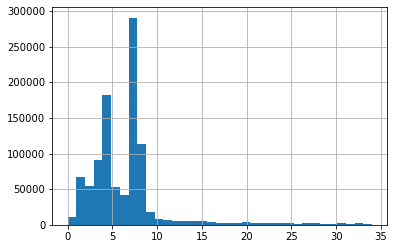

In [56]:
data['month'].hist(bins=35)

+ 대부분의 평점 데이터가 7~8번째 달에 몰려 있다. 
  + 단순히 기간으로 데이터를 선택해 사용하고자 하면 선택 기준을 세우기가 어려워 보인다.
    + 데이터가 몰려 있는 구간을 선택하게 되면 가장 나중 데이터를 상실하게 될 수 있다.
    + 가장 나중의 데이터를 선택하면 상당한 데이터를 상실하게 될 수 있다.
    + 최대한 데이터를 사용하고자 한다면 상당히 긴 기간동안의 데이터를 선택하게 되며 사용자간 활동 기간의 시점과 기간이 달라져 아이디 별로 일관된 세션을 구성하기가 어려워 보인다.

In [58]:
def get_user_active_period(df):
    temp = {}
    temp['active_period'] = df['month'].max() - df['month'].min()
    return pd.Series(temp)

In [61]:
user_active_period = data.groupby(['UserId']).apply(get_user_active_period)

In [76]:
user_active_period

,active_period
UserId,
1,1
2,0
3,0
4,0
5,0
...,...
6036,0
6037,0
6038,0


In [67]:
user_active_period.value_counts()

active_period
0                4365
1                 341
2                 168
3                  85
4                  66
27                 61
5                  61
26                 59
7                  52
6                  51
8                  47
9                  42
25                 42
14                 41
24                 39
13                 39
15                 36
16                 36
10                 34
22                 33
18                 32
12                 32
19                 31
17                 30
29                 29
30                 28
20                 27
23                 27
28                 27
11                 24
31                 17
32                 15
21                 15
33                  8
dtype: int64

array([[<AxesSubplot:title={'center':'active_period'}>]], dtype=object)

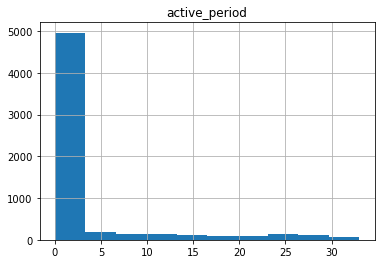

In [63]:
user_active_period.hist()

In [68]:
user_active_period.value_counts().sum()

6040

In [75]:
(user_active_period.value_counts().max() / user_active_period.value_counts().sum()) * 100

72.26821192052981

+ 1달간만 활동한 사용자가 전체의 72%로 상당한 비중을 차지한다.
  + 이러한 사용자의 데이터만 활용한다면 월 별로 데이터를 잘라서 사용해도 유사한 기간 동안 사용자들의 선택을 session으로 쉽게 구성할 수 있을 것 같다. 
  + 해당 사용자의 월별 분포를 살펴보기로 하자.

In [78]:
user_active_period.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='UserId', length=6040)

In [85]:
one_month_user = user_active_period[user_active_period['active_period']==0].index

In [86]:
one_month_user

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   12,   13,
            ...
            6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039],
           dtype='int64', name='UserId', length=4365)

In [96]:
temp = data[data['UserId'].isin(one_month_user)]
temp

,UserId,ItemId,Rating,Time,datetime,month
130,2,1198,4,978298124,2000-12-31 21:28:44,8
64,2,1210,4,978298151,2000-12-31 21:29:11,8
71,2,1217,3,978298151,2000-12-31 21:29:11,8
134,2,2717,3,978298196,2000-12-31 21:29:56,8
88,2,1293,5,978298261,2000-12-31 21:31:01,8
...,...,...,...,...,...,...
999798,6039,1148,4,956758002,2000-04-26 14:06:42,0
999764,6039,912,4,956758029,2000-04-26 14:07:09,0
999771,6039,922,5,956758029,2000-04-26 14:07:09,0
999815,6039,1204,5,956758029,2000-04-26 14:07:09,0


In [117]:
pd.DataFrame(temp.groupby(['UserId']).mean()['month']).value_counts()

month
7.0      1532
4.0       863
8.0       489
3.0       447
1.0       330
2.0       268
5.0       215
6.0       163
0.0        56
31.0        1
13.0        1
dtype: int64

+ 이 데이터도 7월에 몰려 있다. 전반적인 데이터가 7월에 몰려있는데 1월간 활동한 사용자가 다른 달에도 적절히 들어 있지 않을까 했던게 실수였다.
   + 사용 기간을 한달로 정해 영화 평점 데이터를 단기간 동안 쇼핑 사이트에 접속하여 상품을 클릭한 세션 데이터와 유사하게 만들고자 했던 건 전체적인 데이터의 분포를 무시한 안일한 생각이었다.
   + 영화 평점 평가 사이트의 데이터 분포와 쇼핑 사이트 세션 기록 분포의 차이도 생각하지 않고 막연히 유사해지지 않을까 기대했던 것 같다.